## Libraries and Dependencies:

In [53]:
import pandas as pd
import numpy as np
import io
import pickle 
import warnings as war
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

war.filterwarnings('ignore')

# Dataset 


In [54]:

df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,67.0,0,1,228.69,36.6,formerly smoked,1,NaN,NaN,NaN,NaN
1,61.0,0,0,202.21,28.1,never smoked,1,NaN,NaN,NaN,NaN
2,80.0,0,1,105.92,32.5,never smoked,1,NaN,NaN,NaN,NaN
3,49.0,0,0,171.23,34.4,smokes,1,NaN,NaN,NaN,NaN
4,79.0,1,0,174.12,24.0,never smoked,1,NaN,NaN,NaN,NaN


In [55]:
df.shape


(5110, 11)

In [56]:
df.nunique()

age                   104
hypertension            2
heart_disease           2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
Unnamed: 7              0
Unnamed: 8              0
Unnamed: 9              0
Unnamed: 10             0
dtype: int64

In [57]:
print(df['smoking_status'].unique())

['formerly smoked' 'never smoked' 'smokes' 'never smokes']


## Fixing the redundant categorical value in smokers

In [58]:
df['smoking_status'] = df['smoking_status'].str.replace('never smokes', 'never smoked')
df['smoking_status'].value_counts()

smoking_status
never smoked       3436
formerly smoked     885
smokes              789
Name: count, dtype: int64

In [59]:
df


,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,67.0,0,1,228.69,36.6,formerly smoked,1,NaN,NaN,NaN,NaN
1,61.0,0,0,202.21,28.1,never smoked,1,NaN,NaN,NaN,NaN
2,80.0,0,1,105.92,32.5,never smoked,1,NaN,NaN,NaN,NaN
3,49.0,0,0,171.23,34.4,smokes,1,NaN,NaN,NaN,NaN
4,79.0,1,0,174.12,24.0,never smoked,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.75,28.1,never smoked,0,NaN,NaN,NaN,NaN
5106,81.0,0,0,125.20,40.0,never smoked,0,NaN,NaN,NaN,NaN
5107,35.0,0,0,82.99,30.6,never smoked,0,NaN,NaN,NaN,NaN
5108,51.0,0,0,166.29,25.6,formerly smoked,0,NaN,NaN,NaN,NaN


## Exploratory Data Analysis 

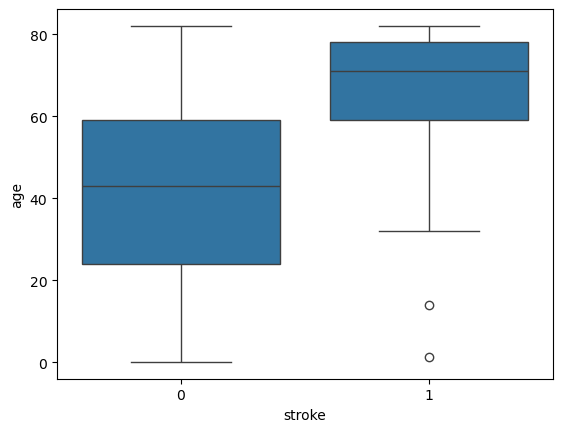

In [60]:
sn.boxplot(data=df, x='stroke', y='age')
plt.show()

<Axes: xlabel='heart_disease', ylabel='count'>

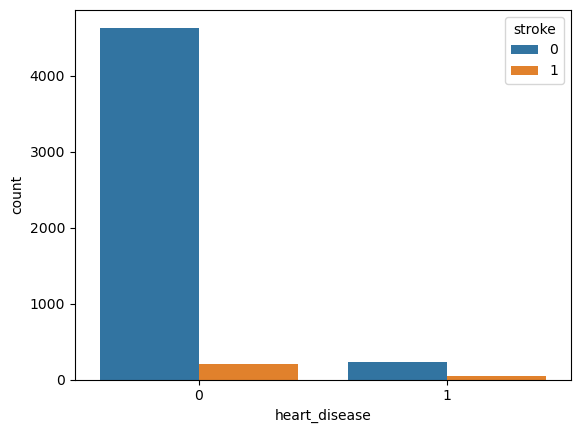

In [61]:
sn.countplot(data=df,x='heart_disease',hue='stroke')

## Keeping the outliers for exceeding glucose level 
    - Might be the case of Diabetic patient.

<Axes: xlabel='stroke', ylabel='avg_glucose_level'>

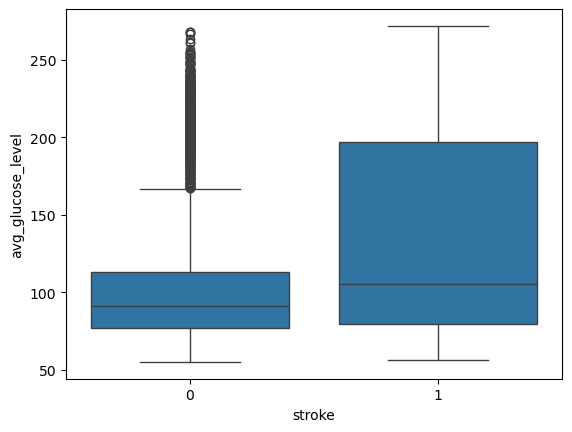

In [62]:
sn.boxplot(data=df, x='stroke', y='avg_glucose_level')

<Axes: xlabel='smoking_status', ylabel='count'>

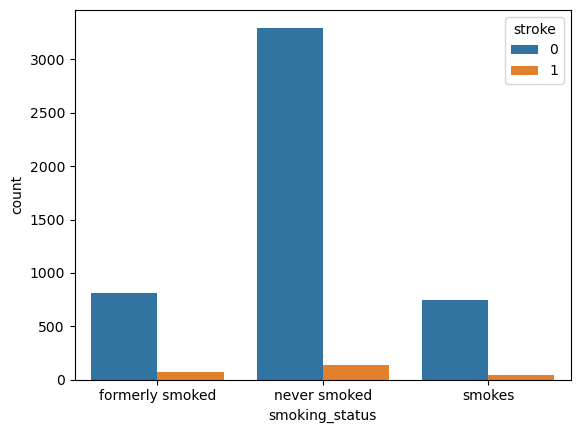

In [63]:
sn.countplot(data=df, x='smoking_status', hue='stroke')

In [64]:
print("Columns after drop:", df.columns.tolist())

Columns after drop: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10']


In [65]:
feature_cols = ['hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'smoking_status']
target_col = 'stroke'

In [66]:
missing = [c for c in feature_cols + [target_col] if c not in df.columns]
if missing:
    raise ValueError("Missing expected", missing)

X = df[feature_cols].copy()   
y = df[target_col].copy().astype(int)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=40
)

print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts())


X_train shape: (3832, 5) X_test shape: (1278, 5)
y_train distribution:
 stroke
0    3645
1     187
Name: count, dtype: int64


In [68]:
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns to encode:", cat_cols)

encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X_train.loc[:, col] = X_train.loc[:, col].fillna("UNKNOWN")
    X_test.loc[:, col]  = X_test.loc[:, col].fillna("UNKNOWN")
    X_train.loc[:, col] = le.fit_transform(X_train.loc[:, col])
    unseen_test_vals = set(X_test.loc[:, col].unique()) - set(le.classes_)
    if unseen_test_vals:
        new_classes = np.concatenate([le.classes_, np.array(list(unseen_test_vals))])
        le.classes_ = new_classes
    X_test.loc[:, col] = le.transform(X_test.loc[:, col])
    encoders[col] = le


Categorical columns to encode: ['smoking_status']


In [69]:
num_cols = [c for c in feature_cols if c not in cat_cols]
for c in num_cols:
    X_train.loc[:, c] = pd.to_numeric(X_train.loc[:, c], errors='coerce')
    X_test.loc[:, c]  = pd.to_numeric(X_test.loc[:, c], errors='coerce')
    med = X_train.loc[:, c].median()
    X_train.loc[:, c] = X_train.loc[:, c].fillna(med)
    X_test.loc[:, c]  = X_test.loc[:, c].fillna(med)

In [70]:
print("\nAfter encoding/imputing:")
print("X_train head:\n", X_train.head())
print("X_test head:\n", X_test.head())
print("encoders keys:", list(encoders.keys()))


After encoding/imputing:
X_train head:
       hypertension  heart_disease  avg_glucose_level   bmi smoking_status
4111             0              0             120.15  27.3              1
3700             0              0             196.50  37.7              1
2138             0              0              92.59  24.6              0
2522             0              0              84.31  25.9              2
323              0              0              90.12  35.4              1
X_test head:
       hypertension  heart_disease  avg_glucose_level   bmi smoking_status
4370             0              0              84.03  25.3              1
1648             0              0             105.47  26.2              1
2423             0              0              99.49  23.4              1
5053             0              0              55.84  27.8              1
836              0              0             110.76  24.7              0
encoders keys: ['smoking_status']


## Shape of Train and Test

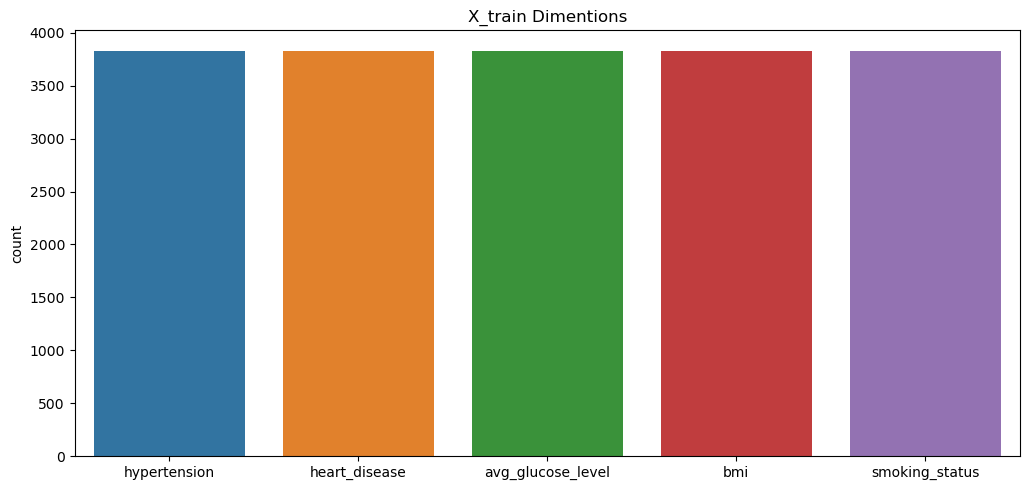

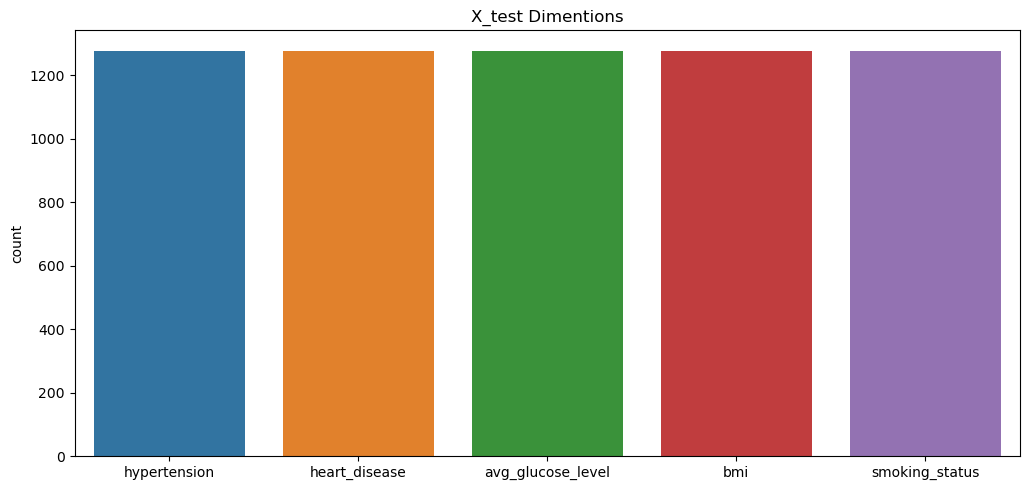

In [71]:
def train_test_shapes(dataset = [X_train, X_test]):
    data_type = ["X_train", "X_test"]
    # plt.figure(figsize=(20,5))
    for i, data in enumerate(dataset, start=0):
        plt.figure(figsize=(20,5))
        plt.subplot(1,2, i+1)
        plt.title(f"{data_type[i]} Dimentions")
        sn.countplot(data=data)
        plt.tight_layout()
        plt.show()
train_test_shapes()

## Datatype conversion:
    - Object -> Int

In [72]:
X_train.info(),print('\n'), X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3832 entries, 4111 to 580
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   hypertension       3832 non-null   int64  
 1   heart_disease      3832 non-null   int64  
 2   avg_glucose_level  3832 non-null   float64
 3   bmi                3832 non-null   float64
 4   smoking_status     3832 non-null   object 
dtypes: float64(2), int64(2), object(1)
memory usage: 179.6+ KB


<class 'pandas.core.frame.DataFrame'>
Index: 1278 entries, 4370 to 2699
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   hypertension       1278 non-null   int64  
 1   heart_disease      1278 non-null   int64  
 2   avg_glucose_level  1278 non-null   float64
 3   bmi                1278 non-null   float64
 4   smoking_status     1278 non-null   object 
dtypes: float64(2), int64(2), object(1)
memory usage: 5

(None, None, None)

## Type Conversion:

In [73]:
def type_conversion(dataset : list) -> pd.DataFrame:
    for key, value in dataset.items():
        try:
            if key == 'X_train':
                X_train['smoking_status'] = value['smoking_status'].astype(int)
            if key == 'X_test':
                X_test['smoking_status'] = value['smoking_status'].astype(int)
        except Exception as error:
            print(f"{error}")
    return X_train, X_test

Training_set = type_conversion(
                dataset={
                    'X_train':X_train, 
                    'X_test' : X_test
                    }
)

In [74]:
X_train, X_test = Training_set
X_train.dtypes 

hypertension           int64
heart_disease          int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int32
dtype: object

In [75]:
X_test.dtypes

hypertension           int64
heart_disease          int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int32
dtype: object

## Estimator Training and CrossValidation:

In [76]:
def Model(models : dict) -> list:
    model_w_accuracy = {}
    the_honored_one = []

    for model in range(len(list(models))):
        estimator = list(models.values())[model]
        
        ## Training pipeline:
        estimator.fit(X_train, y_train)

        ## Predictions:
        y_pred = estimator.predict(X_test)

        ## Evaluation Metrics:
        print(f"{list(models.keys())[model]}")
        print(classification_report(y_test, y_pred))
        accuracy = accuracy_score(y_test, y_pred)
        model_w_accuracy[estimator] = accuracy
    
    # Accuracy Score - Wise model Selection.
    for model in range(len(list(models))):
        if (list(model_w_accuracy.values()))[model] == max(list(model_w_accuracy.values())):
            the_honored_one.append(list(model_w_accuracy.keys())[model])
            
    return the_honored_one[0]
        
model = Model(models={
    "RandomForestClassifier" : RandomForestClassifier(n_estimators=100),
    "XgboostClassifier": XGBClassifier(n_estimators=100),
    "GradientBoostingClassifier" : GradientBoostingClassifier(n_estimators=100)
})

RandomForestClassifier
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1216
           1       0.09      0.02      0.03        62

    accuracy                           0.94      1278
   macro avg       0.52      0.50      0.50      1278
weighted avg       0.91      0.94      0.93      1278

XgboostClassifier
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1216
           1       0.36      0.06      0.11        62

    accuracy                           0.95      1278
   macro avg       0.66      0.53      0.54      1278
weighted avg       0.93      0.95      0.93      1278

GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1216
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1278
   macro avg       0.48      0.50      0.49      1278
weight

## Cross Validator and Prediction Pipeline:

In [84]:
def gridSearch(grid : dict, best_model : tuple):
    for model_name, model_use in best_model:
        best_params = {}
        best_score = []

        randomCV_model = RandomizedSearchCV(
                estimator = model_use,
                param_distributions=grid,
                cv = 5,
                scoring="accuracy",
                n_jobs=-1,
                verbose=1
                )
        
        randomCV_model.fit(X_train, y_train)
        y_random_pred = randomCV_model.predict(X_test)

        ## Adding the Artifacts i.e Best HyperParameters and Accuracy 
        best_params[model_name] = randomCV_model.best_params_
        best_score.append(randomCV_model.best_score_)
        print(best_params)
        print("ACCURACY => ",*best_score)

    return randomCV_model 

enhanced_model = gridSearch(grid = dict(
    n_estimators=[200, 300, 400],
    max_depth=[4, 6, 8],
    learning_rate=[0.01, 0.05, 0.1],
    subsample=[0.7, 0.8, 0.9],
    colsample_bytree=[0.7, 0.8, 0.9],
    min_child_weight=[1, 3, 5],
    gamma=[0, 0.1, 0.2],
    scale_pos_weight=[1, 3, 5],
    reg_alpha=[0, 0.01, 0.1],
    reg_lambda=[1, 1.5, 2]
),
    best_model=[("XgBoostClassifier",  model)]
)

def prediction(new_test_data : pd.DataFrame, label_mapping : dict, final_model):
    try:
        xg_model = final_model
        y_new_pred = xg_model.predict(new_test_data)

        y_pred_category = np.array([label_mapping[pred] for pred in y_new_pred])
    
    except Exception as error:
        print(error)
    pickle.dump(xg_model, open('Best_model/TheHonouredOne.pkl', "wb"))
    return sorted(y_pred_category, reverse=True)

prediction(
            new_test_data=X_test.iloc[:2000],
            label_mapping={
               0:"No Stroke",
               1:"Stroke"
           },
           final_model=enhanced_model
    )

    

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'XgBoostClassifier': {'subsample': 0.7, 'scale_pos_weight': 1, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.9}}
ACCURACY =>  0.948069348892467


['Stroke',
 'Stroke',
 'Stroke',
 'Stroke',
 'Stroke',
 'Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Stroke',
 'No Strok